In [409]:
# Define the ASM model constants

# Stoichiometry (all dimensionless)

YA  = 0.24;      # Heterotrophic yield
YH  = 0.67;      # Autotrophic yield
fP  = 0.08;      # Fraction of biomass yielding particulate products
iXB = 0.086;     # Mass of nitrogen per mass of COD in biomass
iXP = 0.06;      # Mass of nitrogen per mass of COD in products from biomass

# Kinetics parameters
muH   = 3.47e-5; # Max. specific growth rate for heterotrophic biomass [1/day]
KS    = 0.02;    # Half-saturation coefficient for heterotrophic biomass [g/m^3]
KOH   = 0.0002;  
KNO   = 0.0005;
bH    = 4.86e-6;
etag  = 0.8;
etah  = 0.4;
kh    = 2.31e-5;
KX    = 0.02;
muA   = 5.79e-6;
KNH   = 0.001;
KOA   = 0.0004;
bA    = 4.86e-6;
ka    = 9.26e-4;
kLa   = 0.00243;
SOsat = 0.00928;


In [398]:
# Read the CFD data

import csv
import numpy as np

# Create the data arrays
time = list()
SS = list()
XS = list()
XBH = list()
XBA = list()
XP = list()
SO = list()
SNO = list()
SNH = list()
SND = list()
XND = list()

# Open and read the data file
with open('postProcessing/volFieldValue1/0/volFieldValue.dat') as csvfile:

    reader = csv.reader(csvfile, delimiter='\t')
    
    # Skip the header lines
    for _ in range(4):
        next(reader)
    
    # Read the data
    for row in reader:
        time.append(float(row[0]))
        SS.append(float(row[1]))
        XS.append(float(row[2]))
        XBH.append(float(row[3]))
        XBA.append(float(row[4]))
        XP.append(float(row[5]))
        SO.append(float(row[6]))
        SNO.append(float(row[7]))
        SNH.append(float(row[8]))
        SND.append(float(row[9]))
        XND.append(float(row[10]))
        
# Convert to numpy arrays
time = np.array(time)
SS = np.array(SS)
XS = np.array(XS)
XBH = np.array(XBH)
XBA = np.array(XBA)
XP = np.array(XP)
SO = np.array(SO)
SNO = np.array(SNO)
SNH = np.array(SNH)
SND = np.array(SND)
XND = np.array(XND)

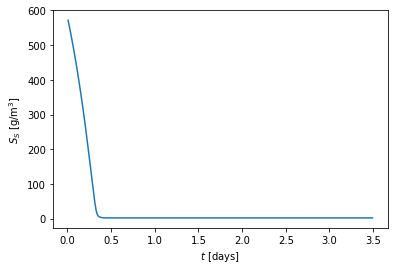

In [399]:
# Plot the readily biodegradable substrate (SS)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time/86400, SS*1000)
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$S_S$ [g/m$^3$]')
plt.show()

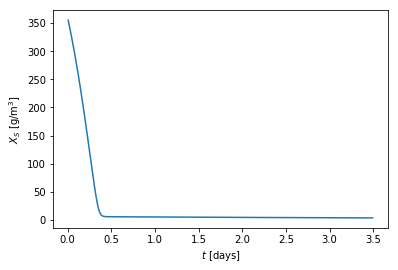

In [400]:
# Plot the slowly biodegradable substrate (XS)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time/86400, XS*1000)
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$X_S$ [g/m$^3$]')
plt.show()

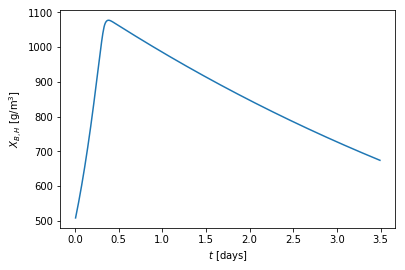

Maximum value of XBH = 1076.981 [g/m^3]


In [401]:
# Plot the active heterotrophic biomass (XBH)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time/86400, XBH*1000)
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$X_{B,H}$ [g/m$^3$]')
plt.show()

print("Maximum value of XBH = {} [g/m^3]".format(max(XBH)*1000))

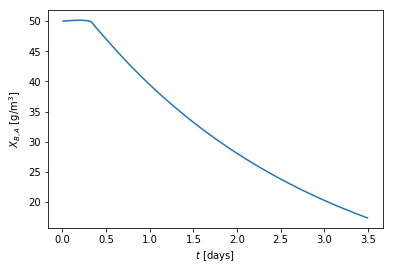

In [402]:
# Plot the active autotrophic biomass (XBA)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time/86400, XBA*1000)
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$X_{B,A}$ [g/m$^3$]')
plt.show()

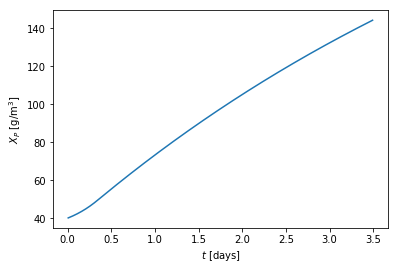

In [403]:
# Plot the particulate products arising from biomass decay (XP)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time/86400, XP*1000)
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$X_P$ [g/m$^3$]')
plt.show()

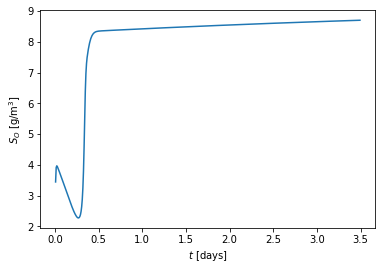

In [404]:
# Plot the oxygen (SO)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time/86400, SO*1000)
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$S_O$ [g/m$^3$]')
plt.show()

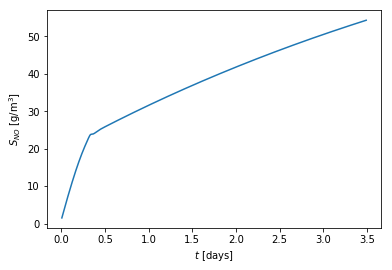

In [405]:
# Plot the nitrate and nitrite (SNO)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time/86400, SNO*1000)
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$S_{NO}$ [g/m$^3$]')
plt.show()

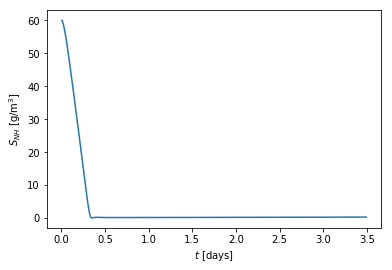

In [406]:
# Plot the ammonia and ammonium nitrogen (SNH)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time/86400, SNH*1000)
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$S_{NH}$ [g/m$^3$]')
plt.show()

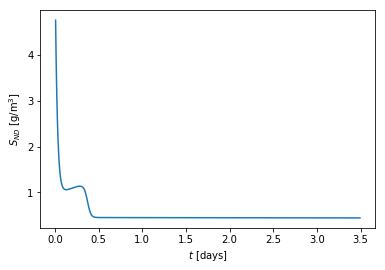

In [407]:
# Plot the soluble biodegradable organic nitrogen (SND)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time/86400, SND*1000)
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$S_{ND}$ [g/m$^3$]')
plt.show()

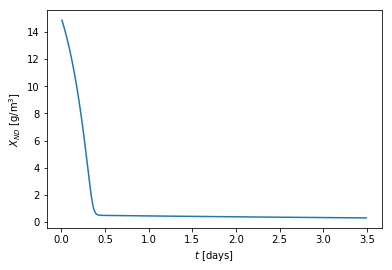

In [408]:
# Plot the particulate biodegradable organic nitrogen (XND)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time/86400, XND*1000)
plt.xlabel(r'$t$ [days]')
plt.ylabel(r'$X_{ND}$ [g/m$^3$]')
plt.show()